# Introduction

This notebook looks at the auditory data in the DOD dataset, producing numerous PCA visualizations left for interpretation.

# PCA functions

In [1]:
# Required libraries
# !pip install mpl_axes_aligner openpyxl
# !pip install numpy pandas scikit-learn seaborn missingno

In [2]:
# Loading the data
import pandas as pd
import numpy as np

def load_data(path): # = 'DOD_clinical_data.xlsx'
	xlsx = pd.ExcelFile(path)
	data = {}
	for sheetname in xlsx.sheet_names:
		sheet = pd.read_excel(xlsx, sheet_name=sheetname)
		data[sheetname] = sheet
	return data

In [3]:
# PCA
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import mpl_axes_aligner

def principal_component_analysis(dataframe: pd.DataFrame, columns: list[str], n_components: int, c_components: int, scree=True, biplot=True, pca_title="PCA Graph", highlight=[str]):

	"""
	Params:
	- dataframe: A dataframe containing all the samples (participants) as rows and the indexes being the ID.
	- columns: A list of strings that are the columns in dataframe. They must be valid columns in the dataframe.
	- n_components: Number of components to pass into PCA. If you don't know, just use the # of columns as your n_components.
	- c_components: Number of components for communality calculation.
	- label_ptah: Path to DOD_clinical_labels.xlsx
	- scree: If you want the scree plot of the PCA
	- biplot: If you want the biplot (PC1 & PC2, loadings) of the PCA.
	- pca_title: Whatever you want to name the graph
	- highlight: Variables you want to highlight in the loading plot
	Note: This PCA assumes that all your variables are NUMERIC
	"""

	print("\n --- START PCA ---\n")

	# Shaping our data for PCA
	data = dataframe[columns]
	data_raw = data.copy()
	data = data.dropna(axis=1, how='all')
	dropped_cols = data_raw.columns.difference(data.columns)
	print("Dropped columns (all NA):", dropped_cols.tolist())
	cleaned_columns = []
	for column in columns:
			if column in data.columns and column not in dropped_cols:
				cleaned_columns.append(column)
				data = data[pd.to_numeric(data[column], errors='coerce').notnull()] # Removes all non-numeric rows
	print(f"Total data length after NA removal: {len(data)}")
	columns = cleaned_columns
	scaled_data = preprocessing.scale(data) # Centering makes the average 0. Scaling makes the standard deviation 1.

	# Input data into PCA
	pca = PCA(n_components=n_components)
	pca.fit(scaled_data) # Fit data
	pca_data = pca.transform(scaled_data) # Generate coordinates for graph

	# Look at the variance in each PC and plot
	per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
	labels = ['PC' + str(x) for x in range (1, len(per_var)+1)]

	# Save loadings
	loading_score = pd.DataFrame(pca.components_.T, columns=labels, index=columns)

	# Scree plot
	if scree:
		bars = plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
		plt.ylabel('Percentage of Explained Variance')
		plt.xlabel('Principal Component')
		plt.title('Scree Plot')
		for bar, val in zip(bars[:3], per_var[:3]): # Just the first three should be enough
			plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f"{val}%", ha='center', va='bottom')
		plt.show()

	# Label each data point in the 2 axes
	if biplot:
		fig,ax = plt.subplots(figsize=(15,8))
		pca_df = pd.DataFrame(pca_data, index=[index for index, __ in data.iterrows()], columns=labels)
		ax.scatter(pca_df.PC1, pca_df.PC2)
		ax.set_title(pca_title)
		ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
		ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
		for sample in pca_df.index:
			ax.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
		ax2 = ax.twinx().twiny() # Plot loadings on this same graph. Credit: https://insidelearningmachines.com/biplot/
		font = {'color':  'g',
			'weight': 'bold',
			'size': 12,
			}
		for col in loading_score.T.columns.values:
			tipx = loading_score.T.loc['PC1',col]
			tipy = loading_score.T.loc['PC2',col]
			ax2.arrow(0, 0, tipx, tipy, color = 'blue' if col in highlight else 'r', alpha = 0.5)
			ax2.text(tipx, tipy, col, fontdict = font, ha = 'center', va = 'center')
		mpl_axes_aligner.align.xaxes(ax, 0, ax2, 0, 0.5)
		mpl_axes_aligner.align.yaxes(ax, 0, ax2, 0, 0.5)
		plt.show()

	# Communality calculation
	loadings = pca.components_.T * np.sqrt(pca.explained_variance_)	# Loadings matrix (variables * components)
	communalities = np.sum(loadings[:, :c_components]**2, axis=1) # Communality = sum of squared loadings for first m PCs
	communalities_percent = (communalities * 100).round(2)
	communalities_df = pd.DataFrame({
			'Variable': columns,
			'Communality': communalities_percent
	}).set_index('Variable')
	print("\nCommunalities Percentage (first", c_components, "components):")
	print(communalities_df.reindex(communalities_df.abs().sort_values(by='Communality', ascending=False).index))

	# Let's focus on the PC's that explain 90-95% of the data
	threshold = 0.95
	loading_tables = []
	total_variance = 0.0
	pc_index = 0
	while total_variance < threshold and pc_index < len(pca.explained_variance_ratio_):

		# Update variance tracker
		total_variance += pca.explained_variance_ratio_[pc_index]

		# Sort the respective PC based off of loadings
		sorted = loading_score.iloc[:, pc_index].copy()
		sorted = sorted.reindex(sorted.abs().sort_values(ascending=False).index)
		sorted = sorted.reset_index().rename(columns={'index': f'PCA{pc_index+1}_index'})

		# Save and move on to the next
		loading_tables.append(sorted)
		pc_index += 1

	# Combine into 1 giant dataframe
	all_loading_dfs = pd.concat(loading_tables, axis=1)
	print(f"\nLoadings: {pc_index} PCs needed in order to explain {total_variance*100:.2f}% variation\n")
	print(all_loading_dfs.to_string())

	print("\n --- END PCA ---\n")

	# Return data for K-Means clustering
	return scaled_data, pca_df


In [4]:
# Show the PCA graph with the colors of the clinical & military profiles
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def graph_classification(pca_df):

    """
    Params:
    - pca_df: must have "Clinical Profile" and "Military Profile" columns
    """

    # Plot Clinical Profile
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="PC1", y="PC2", hue="Clinical Profile", data=pca_df)
    plt.title("PCA - Clinical Profile")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Plot Military Profile
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="PC1", y="PC2", hue="Military Profile", data=pca_df)
    plt.title("PCA - Military Profile")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [5]:
# Grab the average between a left and right column. Unlike .mean(), this handles NA values.
def average_columns(left_column, right_column):

	"""
	Example usage:
	test_df['PTA_A'] = average_columns(test_df['PTA_A_L'], test_df['PTA_A_R'])
	"""

	averages = []
	for left, right in zip(left_column.values, right_column.values):
		average = 0
		if left == None and right == None:
			average = None
		elif left == None:
			average = right
		elif right == None:
			average = left
		else:
			average = (float(left) + float(right))/2
		averages.append(average)
	return averages


# Finding salient variables with PCA.

PCA review:
- PC's are ranked by the amount of variability they capture.
- PC's are a linear combination of the variables in your dataset.
	- The coefficients of the linear combinations are called "loadings"

Loading notes:
- The sign tells you whether the INCLUSION (+) or ABSENSE (-) of it contributes to the PC.
- The mangitude tells you how much the inclusion/absense of it contributes (higher = more contribution).

For now, we can look at which variables are informative or redundant. Here are some notes:
- Variables that contribute heavily to the same PC are likely redundant (PCA combines them into the same signal)
- Variables that contribute across many components are important and complex
- Variables with low contributions across many components are probably uninformative

Furthermore, loading plots will tell us information about variables
- Variables grouped together will be positively correlated (tendency to change the same way, but is it safe to call this redundant?)
- Variables opposite to each other w/ respect to the origin are negatively correlated 
- Variables farther to the origin are "stronger" / more influential.

PCA summarizes: Trends, jumps, clusters, and outliers

# Defining the dataset

These are variables that Brett deems as informative:
- Summary & AirCon: PTA LOW PTA MED PTA HIGH & DP AVG LOW DP AVG MED DP AVG HIGH
- Speech: SRT_RIGHT SRT_LEFT (AVGED), QUICKSIN AVG
- Tymp: Peak compliance and Peak pressure

First define some paths

In [6]:
# Change these paths to match your working directory.
label_path = '../data/DOD_clinical_labels_from_excel.xlsx'
logs_path = '../data/Data Processing Logs.xlsx'
data_path = '../data/DOD_clinical_data.xlsx'

Define the dataset: all_df

In [7]:
# -------------------- Loading data --------------------
data = load_data(data_path)
aircon_low_df = data['AirCon'].set_index(data['AirCon']['ID'])
aircon_high_df = data['AirConHigh'].set_index(data['AirConHigh']['ID'])
bonecon_df= data['BoneCon'].set_index(data['BoneCon']['ID'])
aircon_low_df = data['AirCon'].set_index(data['AirCon']['ID'])
speech_df = data['Speech'].set_index(data['Speech']['ID'])
tymp_df = data['Tymp'].set_index(data['Tymp']['ID'])
summary_df = data['Summary'].set_index(data['Summary']['ID'])

# -------------------- Organizing data --------------------
# Organize AirCon Data
aircon_high_df.drop(columns=['RU8000', 'LU8000'], inplace=True) # Redundant info
aircon_all_df = pd.concat([aircon_low_df, aircon_high_df], axis = 1)
aircon_all_df_cleaned = aircon_all_df.replace({"DNC" : None, "NR" : None})
# Average between left and right
aircon_all_df_averaged = aircon_all_df_cleaned.copy()
for column in aircon_all_df_averaged:
	if 'RU' in column:
		right, frequency = column.split('U')
		aircon_all_df_averaged["A_"+frequency] = average_columns(aircon_all_df_averaged[column], aircon_all_df_averaged['LU'+str(frequency)])
aircon_all_df_averaged['PTA_A'] = average_columns(aircon_all_df_averaged['PTA_A_R'], aircon_all_df_averaged['PTA_A_L'])
# Drop the original columns, leaving just the averages
aircon_all_df_final = aircon_all_df_averaged.drop(columns=[*aircon_all_df_cleaned.columns])
print(f"Final AirCon data length: {len(aircon_all_df_final)}")

# Organize BoneCon data
bonecon_df_cleaned = bonecon_df.replace({"DNC" : None, "NR" : None})
keep = 'PTA_B_R	PTA_B_L	RU250	RU500	RU1000	RU2000	RU3000	RU4000	RU6000	RU8000	LU250	LU500	LU1000	LU2000	LU3000	LU4000	LU6000	LU8000'.split('\t')
bonecon_df_cleaned = bonecon_df_cleaned[keep] # Keep only unmasked data since mask doesn't have a lot of data.
# Average between left and right
bonecon_df_averaged = bonecon_df_cleaned.copy()
for column in bonecon_df_averaged:
	if 'RU' in column:
		right, frequency = column.split('U')
		bonecon_df_averaged["B_"+frequency] = average_columns(bonecon_df_averaged[column], bonecon_df_averaged['LU'+str(frequency)])
bonecon_df_averaged['PTA_B'] = average_columns(bonecon_df_averaged['PTA_B_R'], bonecon_df_averaged['PTA_B_L'])
# Drop the original columns, leaving just the averages
bonecon_df_final = bonecon_df_averaged.drop(columns=[*bonecon_df_cleaned.columns])
print(f"Final BoneCon data length: {len(bonecon_df_final)}")

# Organize Speech data
speech_df_cleaned = speech_df.drop(columns=['ID', 'Speech_Date', 'R_LIST', 'L_LIST', 'QuickSIN List 1', 'QuickSIN List 2', 'Notes'])
# Average between left and right. Note: R_WRS_MASK might have a space in the column name.
speech_df_averaged = speech_df_cleaned.copy()
keep = ["QuickSIN_Average_SNR_Loss"]
for column in speech_df_averaged:
	if 'R_' in column and column not in keep:
		_, name = column.split('R_')
		speech_df_averaged[name] = average_columns(speech_df_averaged[column], speech_df_averaged['L_'+str(name)])
# Drop the original columns, leaving just the averages
speech_df_final = speech_df_averaged.drop(columns=list(set([*speech_df_cleaned.columns]) - set(keep)))
print(f"Final Speech data length: {len(speech_df_final)}")

# Organize Tymp data
tymp_df_cleaned = tymp_df.drop(columns=['ID', 'Tymp_Date'])
# Average between left and right
tymp_df_averaged = tymp_df_cleaned.copy()
for column in tymp_df_averaged:
	if 'TR_' in column and column not in keep:
		_, name = column.split('TR_')
		tymp_df_averaged[name] = average_columns(tymp_df_averaged[column], tymp_df_averaged['TL_'+str(name)])
# Drop the original columns, leaving just the averages
tymp_df_final = tymp_df_averaged.drop(columns=list(set([*tymp_df_cleaned.columns]) - set(keep)))
print(f"Final Tymp data length: {len(tymp_df_final)}")

# Organize Summary data
summary_df_columns = ['PTA_pt5to2', 'PTA_3to6', 'PTA_12pt5to16',
		   'PTA_Low', 'PTA_Med', 'PTA_High',
		   'DPavg_Low', 'DPavg_Med', 'DPavg_High']
summary_df_final = summary_df[summary_df_columns]
print(f"Final Summary data length: {len(summary_df_final)}")

# -------------------- Combining data --------------------
# Combine all dataframes
all_df = pd.concat([aircon_all_df_final, bonecon_df_final, speech_df_final, tymp_df_final, summary_df_final], axis = 1)

# -------------------- Appending labels --------------------
# Append military and clinical label information
labels = pd.read_excel(label_path)
all_df['Clinical Profile'] = ['' for _ in range(len(all_df))]
all_df['Military Profile'] = ['' for _ in range(len(all_df))]
for index, row in all_df.iterrows():
	id_val = index
	clinical_match = labels.loc[labels['ID'] == id_val, 'Clinical Profile']
	military_match = labels.loc[labels['ID'] == id_val, 'Military Profile']
	if not clinical_match.empty:
		all_df.at[index, 'Clinical Profile'] = clinical_match.iloc[0]
	if not military_match.empty:
		all_df.at[index, 'Military Profile'] = military_match.iloc[0]

# Append demographic (civilian/veteran) and study status (completed/not completed)
processing_logs = load_data(logs_path)['Audiology']
all_df['Civ/Vet'] = ['' for _ in range(len(all_df))]
all_df['Study Status'] = ['' for _ in range(len(all_df))]
for index, row in all_df.iterrows():
	id_val = index
	demographic_match = processing_logs.loc[processing_logs['ID'] == id_val, 'Civ/Vet']
	studystatus_match = processing_logs.loc[processing_logs['ID'] == id_val, 'Study Status']
	if not demographic_match.empty:
		all_df.at[index, 'Civ/Vet'] = demographic_match.iloc[0]
	if not studystatus_match.empty:
		all_df.at[index, 'Study Status'] = studystatus_match.iloc[0]

# Keep track of some columns here (either logistical, or just have a lot of NA values)
logistic_columns = ['Clinical Profile', 'Military Profile', 'Civ/Vet', 'Study Status']
aircon_drop = ['A_16000', 'A_18000', 'A_20000']
bonecon_drop = ['B_8000', 'B_6000']
summary_drop = ["WRS_MASK", "PTA_12pt5to16"]
drop_columns = aircon_drop + bonecon_drop + summary_drop
BrettColumns = ['PTA_Low', 'PTA_Med', 'PTA_High', 'DPavg_Low', 'DPavg_Med', 'DPavg_High', 'SRT', 'QuickSIN_Average_SNR_Loss', 'PEAKCOMP', 'PEAKPRES']

# -------------------- Filtering data --------------------
# Filter for only first visits
# first_df = all_df.loc[(all_df.index < 2000)] # Length should be around 152

# Filter for only veterans (and implicitly first visits + people that completed the study too)
veteran_df = all_df.loc[(all_df['Civ/Vet'] == 'Veteran')] # Length should be 123

# -------------------- Other --------------------
# Impute with the median
final_df = veteran_df.fillna(value=all_df.apply(pd.to_numeric, errors='coerce').median())

# Convert to float
convert_columns = final_df.columns.difference(logistic_columns)
final_df[convert_columns] = final_df[convert_columns].astype(float)

Final AirCon data length: 203
Final BoneCon data length: 203
Final Speech data length: 203
Final Tymp data length: 202
Final Summary data length: 185


/tmp/ipykernel_6677/2262056520.py:122: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df = veteran_df.fillna(value=all_df.apply(pd.to_numeric, errors='coerce').median())


Run PCA


 --- START PCA ---

Dropped columns (all NA): []
Total data length after NA removal: 123


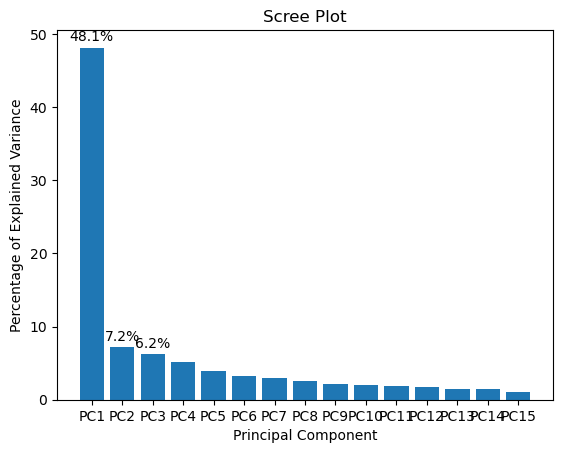

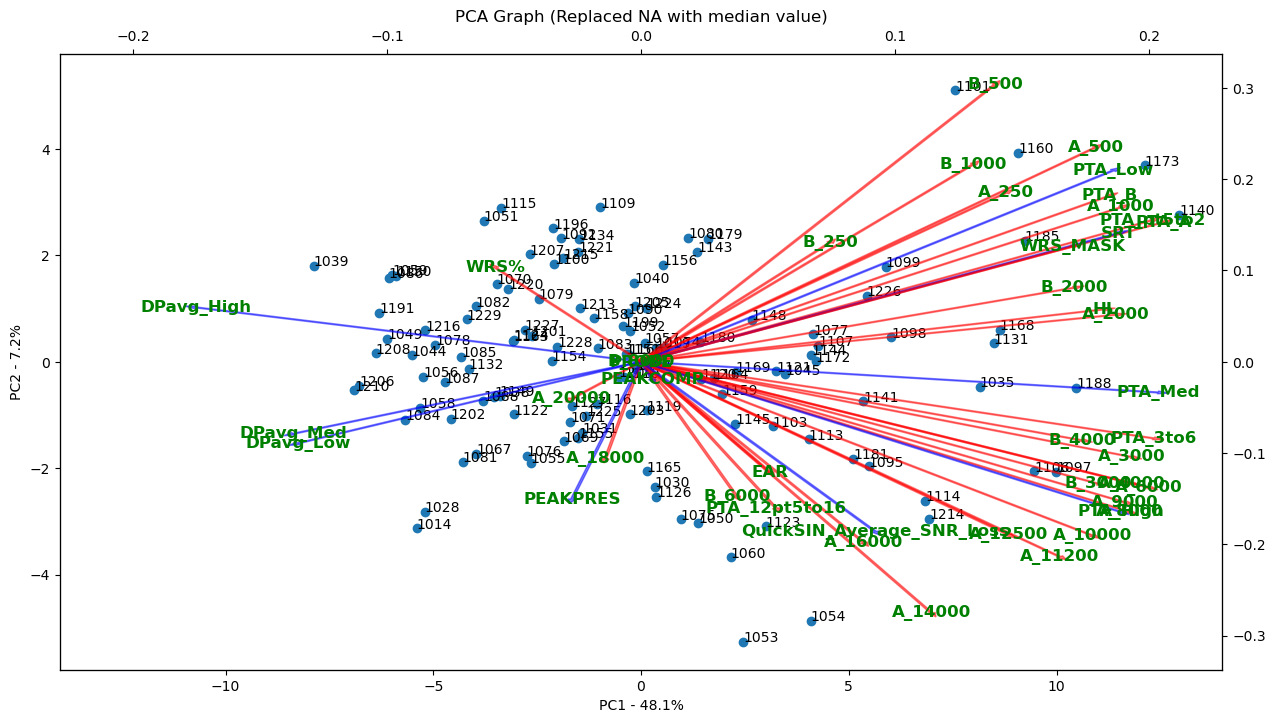


Communalities Percentage (first 3 components):
                           Communality
Variable                              
PTA_A                            93.44
PTA_pt5to2                       89.91
PTA_Med                          88.51
A_6000                           88.12
PTA_3to6                         88.03
PTA_Low                          86.37
A_4000                           85.81
A_500                            85.22
A_3000                           84.41
A_8000                           84.24
A_9000                           81.66
A_1000                           81.63
PTA_High                         81.29
PTA_B                            79.84
SRT                              78.95
B_3000                           76.06
A_10000                          75.59
A_2000                           74.51
A_11200                          69.72
HL                               68.98
B_500                            68.88
B_4000                           67.56
A_14000         

In [8]:
# Run PCA functions
scaled_data, pca_df = principal_component_analysis(dataframe=final_df,
												   columns=final_df.columns.difference(logistic_columns),
												   n_components=15, # Arbitary, just needs to be less than our # of columns
                           c_components=3,
													 scree=True,
                           pca_title="PCA Graph (Replaced NA with median value)",
                           highlight=BrettColumns)

Notes on factor analysis:
- A common way to look at PCA number is to consider them as factors.
- A statistician will fight to the death telling you not to treat PCA as a factor analysis, but it's generally accepted in machine learning.
- To have a factor analysis interpretation, we treat variables as clusters and see how much variation each variable share/contributes within a PC

Factor analysis terms:
- Communality is the amount of variation a variable contributes to the first "m" number of Principle Components

Notes:
- After filtering for only veterans, the higher ranges of AirCon don't contribute much to PC1

# K-Means cluster analysis

K-Means clusters data points. 
- It does so by choosing random K centroids, and then repeatedly choosing K centroids until the distance between data points and their closest centroid is minimized.
- It also has the ability to do so in a high-dimensional space (like our data)
- Quick Caveat: Because centroids are chosen randomly, there is an element of randomness in this. That is, running K-means again may produce different results

General Approach: Applying the K-means clustering to the data
  1) Find the optimal amount of clusters as defined by the algorithm.
  2) Run K-means on that # of clusters.
  3) Find out why the algorithm chose to cluster those datapoints the way it did.

# K-Means functions

In [9]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import itertools
import math


# 1) Figure out optimal clusters
def elbow_k_means(df: pd.DataFrame, max_k: int):

  """
  Params:
  - df: must have indices as examples
  - max_k: most amount of clusters you wanna try
  Interpretation note: Look at where it starts to flatten. That will be the optimal K.
  """

  means = []
  inertias = []
  for k in range (1, max_k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df)
    means.append(k)
    inertias.append(kmeans.inertia_)
  fig = plt.subplots(figsize=(8,6))
  plt.plot(means, inertias, 'o-')
  plt.xlabel('Clusters')
  plt.ylabel('Inertia')
  plt.grid(True)
  plt.show()

# 2) Run K-means on that # of clusters
def general_k_means(df: pd.DataFrame, k: int, random_state: int, prints=True):

  """
  Params:
  - df: must have indices as examples
  - k: number of clusters
  - prints: print statements
  """

  # Clean up
  df_result = df.copy()
  df_result.dropna(inplace=True)
  if prints:
    print(f"Length after dropping NA values, {len(df_result)}")

  # Standardize
  df_scaled = preprocessing.scale(df_result) # Centering makes the average 0. Scaling makes the standard deviation 1.

  # Create clusters
  kmeans = KMeans(n_clusters=k,
                  random_state=random_state,
                  n_init=10, # Increased n_init might lead to less variation in K-mean clusters due to randomness
                  max_iter=1000,
                  tol=0)
  kmeans.fit(df_scaled)

  # Return the df with labeled clusters
  df_result['kmeans'] = kmeans.labels_
  return df_result

# 3) Figure out why K-means is clustering it that way
def plot_k_means(df: pd.DataFrame, x: str, y: str):

  """
  Params:
  - df: MUST have kmeans column
  - kmeans: MUST be a valid column in df
  - x: MUST be a valid column in df (set x and y to "ALL" to plot all)
  - y: MUST be a valid column in df (set x and y to "ALL" to plot all)
  """

  # Plot all combinations of variables
  if x == "ALL" and y == "ALL":

    # Clean columns & shape into list of (column_names, column_datas) pairs
    data = []
    for combination in itertools.combinations(df.drop(columns=['kmeans']), 2):
      x_name, y_name = combination
      df_cleaned = df[[x_name, y_name, 'kmeans']].apply(pd.to_numeric, errors='coerce').dropna()
      if len(df_cleaned) == 0:
        print(f"{x_name} and {y_name} skipped, all NA's")
        continue
      data.append((x_name, y_name, df_cleaned))

    # Define subplots
    n = len(data)
    cols = 5
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 2.5))
    axes = axes.flatten()

    # Create subplots
    for i, (x_name, y_name, df_cleaned) in enumerate(data):
      sns.scatterplot(
          x=x_name,
          y=y_name,
          hue='kmeans',
          data=df_cleaned,
          ax=axes[i]
      )
      axes[i].set_title(f"X={x_name}, Y={y_name}")
      axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

  # Plot the two variables
  else:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=x, y=y, hue='kmeans', data=df)
    plt.title(f"X={x}, Y={y}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


# K-Means visualizataions

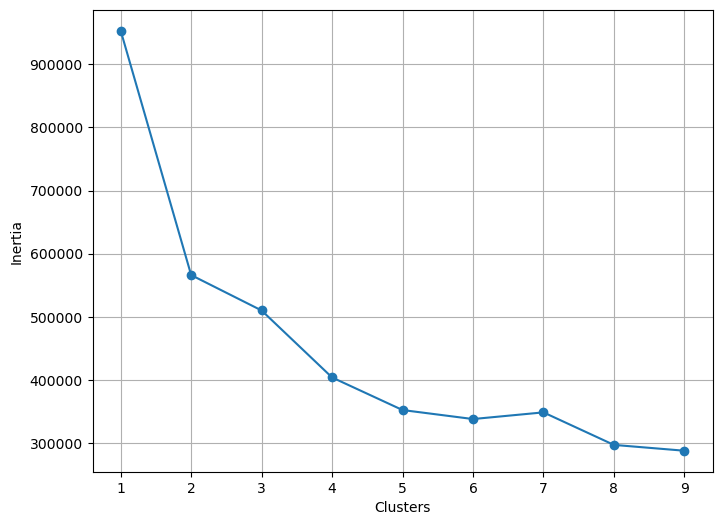

In [10]:
elbow_k_means(df=final_df[final_df.columns.difference(logistic_columns)], max_k=10)

# We need to pick where the slope begins to flatten.
# It seems like it starts to flatten around 3, but since 3 is too little, let's just pick 4.

Length after dropping NA values, 123


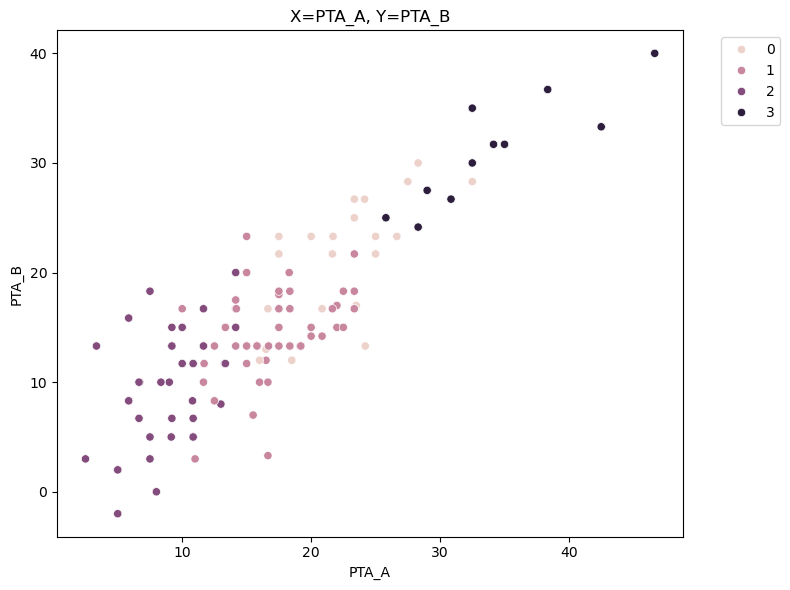

In [11]:
# Append a column called "kmeans"
k_means_df = general_k_means(df=final_df[final_df.columns.difference(logistic_columns)], k=4, random_state=50)

# Interpretting K-Means: a few columns
plot_k_means(df=k_means_df, x='PTA_A', y='PTA_B')

# Interpretting K-Means: all combinations of x & y axes
# plot_k_means(df=k_means_df, x='ALL', y='ALL')

# Extra visualizations

Defining a grand dataset

In [12]:
# Before running both of them together, let's ensure they're the same length & have the same indices.
print(f"Same length: {len(k_means_df) == len(pca_df) == len(final_df)}")
print(f"Same indices: {((k_means_df.index == pca_df.index) == (final_df.index == pca_df.index)).all()}")

Same length: True
Same indices: True


In [13]:
# If the dataframes are the same length and all indices are the same, let's combine all the information we have.
combined_df = pd.concat([pca_df, k_means_df['kmeans'], final_df])
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 369 entries, 1014 to 1229
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PC1                        123 non-null    float64
 1   PC2                        123 non-null    float64
 2   PC3                        123 non-null    float64
 3   PC4                        123 non-null    float64
 4   PC5                        123 non-null    float64
 5   PC6                        123 non-null    float64
 6   PC7                        123 non-null    float64
 7   PC8                        123 non-null    float64
 8   PC9                        123 non-null    float64
 9   PC10                       123 non-null    float64
 10  PC11                       123 non-null    float64
 11  PC12                       123 non-null    float64
 12  PC13                       123 non-null    float64
 13  PC14                       123 non-null    float64


<Axes: xlabel='PC1', ylabel='PC2'>

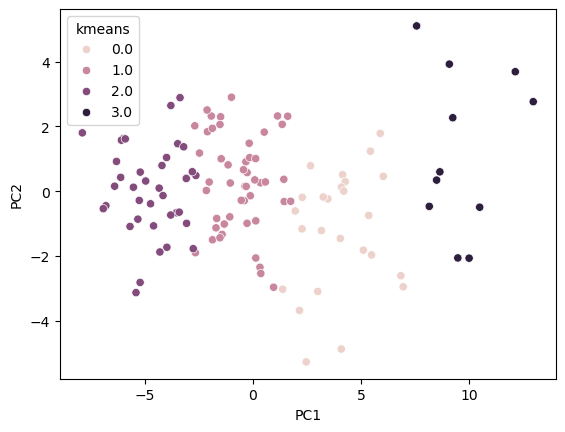

In [14]:
# Plot PC1 and PC2, with the hue being the kmeans cluster
# Prediction: kmeans will follow a gradient along the x-axis (PC1)
sns.scatterplot(x="PC1",y="PC2",hue="kmeans",data=combined_df)

<Axes: xlabel='PC1', ylabel='PC2'>

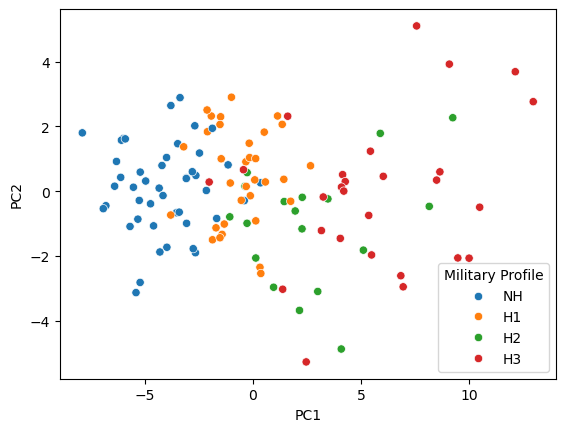

In [15]:
# Plot PC1 and PC2, with the hue being the profile cluster
# Prediction: Military profile will follow a gradient along the x-axis (PC1)
sns.scatterplot(x="PC1",y="PC2",hue="Military Profile",data=combined_df)

<Axes: xlabel='PC1', ylabel='PC2'>

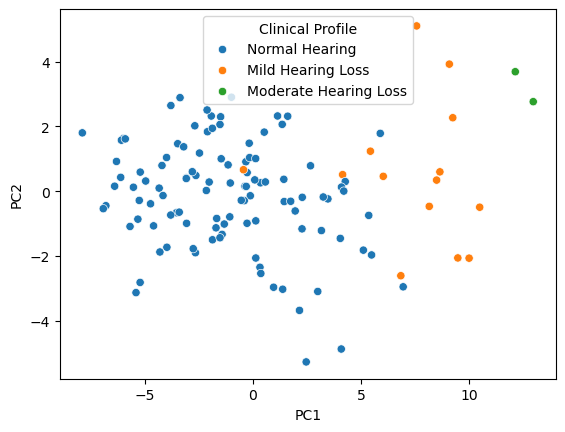

In [16]:
# Plot PC1 and PC2, with the hue being the profile cluster
# Prediction: Clinical profile will follow a gradient along the x-axis (PC1)
sns.scatterplot(x="PC1",y="PC2",hue="Clinical Profile",data=combined_df)

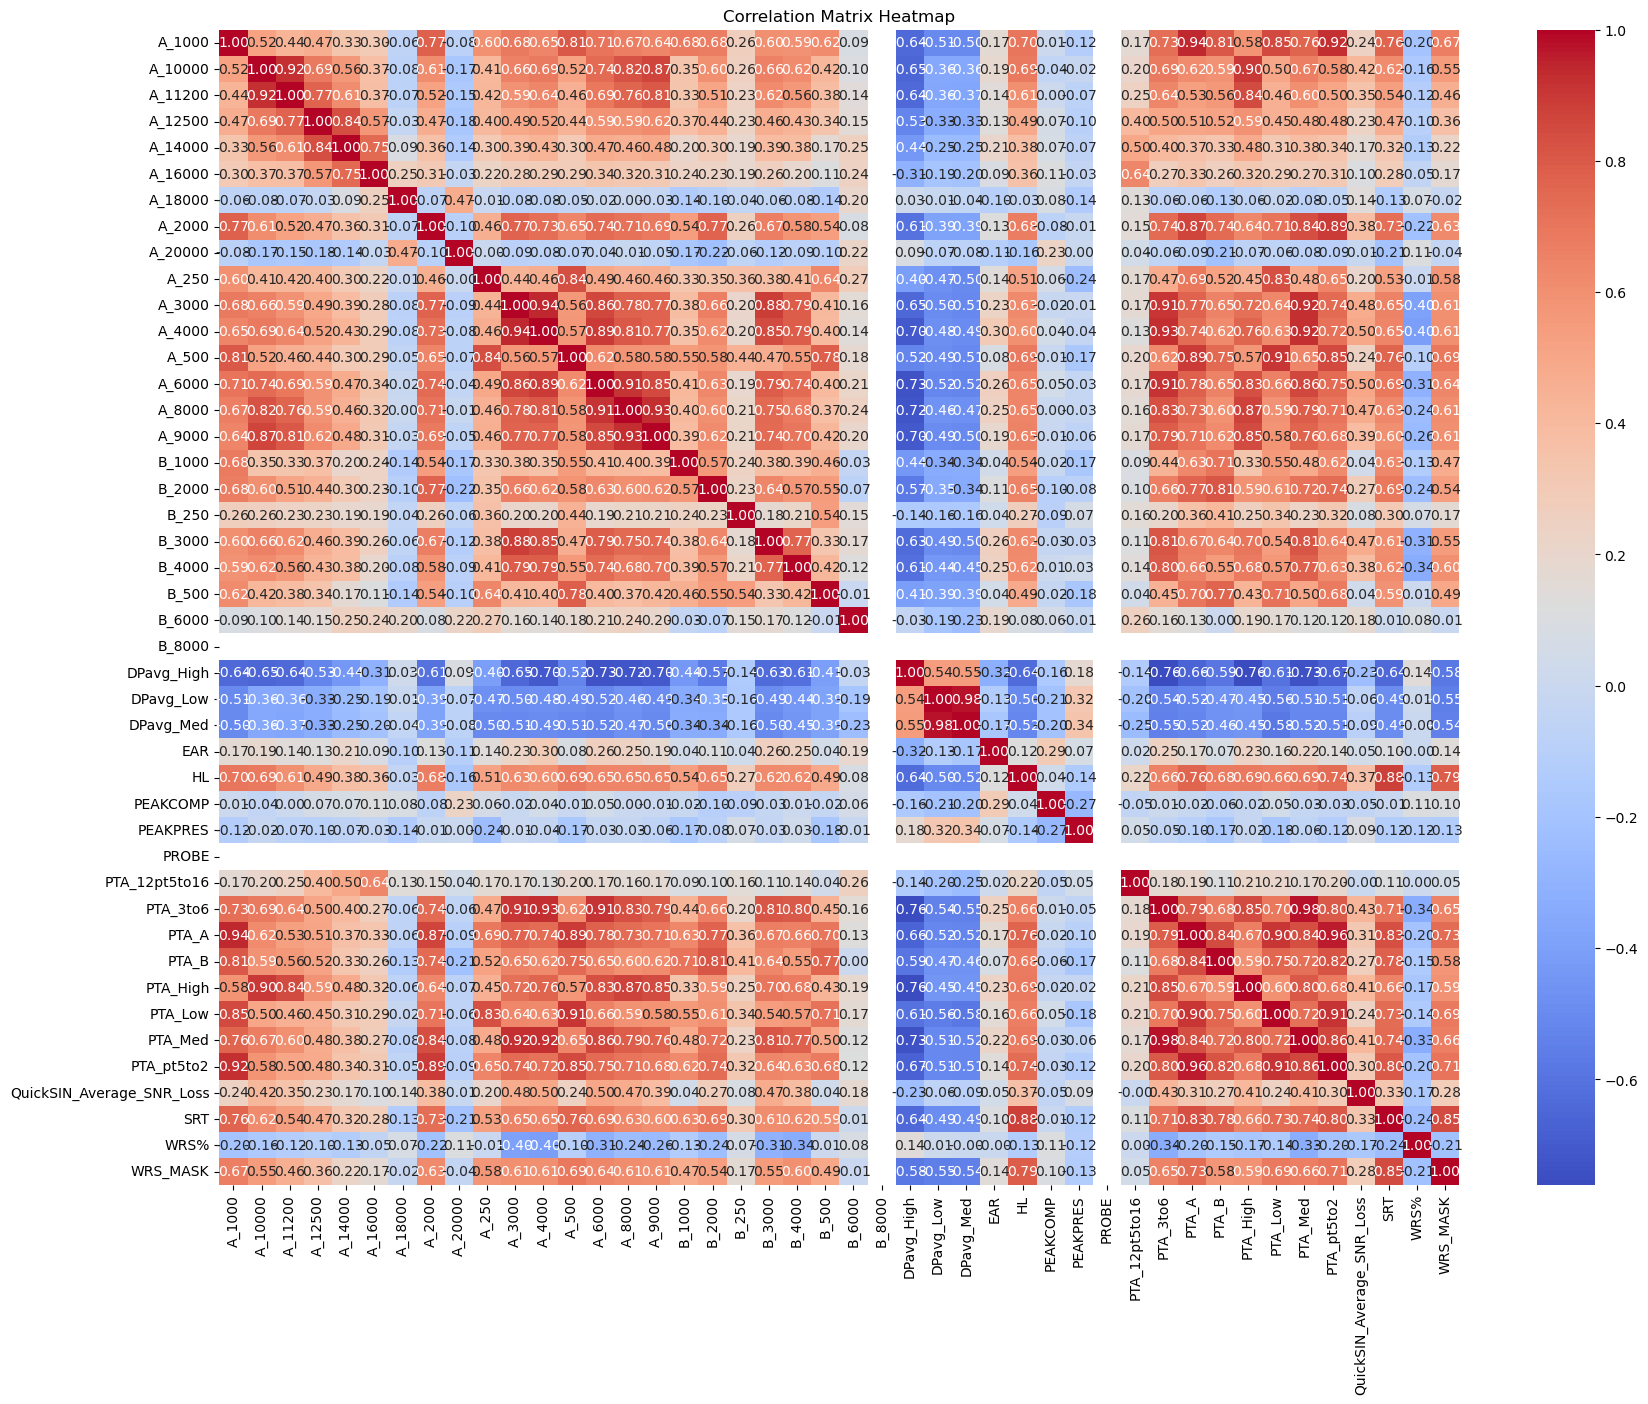

In [17]:
# Correlation matrix (for fun)
correlation_matrix = final_df[final_df.columns.difference(logistic_columns)].corr()

# Heat map
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()